In [1]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt
from emojihunt import *
import json

Current project version:
emojihunt==1.1.1


# Template For EmojiHunt Project!

## EmojiHunt()
This is your emojihunt environment class you will use it for generating problem images, testing your configuration and getting your final scores on the trials.
### EmojiHunt.get_config()
This returns the dictionary of the configuration for the EmojiHunt. You can change the booleans in this dictionary to make the problem harder or easier.
### EmojiHunt.update_config(dict)
This writes the passed dictionary as the new configuration for the EmojiHunt. It should be formated as recived from .get_config(). 
### EmojiHunt.generate_image_and_points()
This returns 3 objects the target image, the example emoji and the ground truth real points. This function is avalible so you can test your method without needing to perform full official tests. The emoji image and the test target image are simple cv2 formated color images (BGR, numpy uint8). The ground truth points are a list of tuples of points [(x_0,y_0)..(x_n,y_n)]
### EmojiHunt.generate_image_and_points(ground_truth, predicted)
This function gives the score between two sets of emoji points, the ground truth given by .generate_image_and_points() and the prediction points. 
### EmojiHunt.offical_test(function, config)
For this function you explicitly give a callable object (either fucntion or class method) that takes in the positional arguments of image, sample_emoji. This function then runs multiple tests on this function and prints a report based on the config and the socres. Official tests are seeded so the test for each config is always the same. 
### Examples of the usage of all these methods are given below.


In [2]:
emoji_hunt_object = EmojiHunt() 
print(json.dumps(emoji_hunt_object.get_config(), indent=2))
def test_bad_function(image, emoji):
    return [(random.randint(0,512),random.randint(0,512))]
emoji_hunt_object.offical_test(test_bad_function,emoji_hunt_object.get_config())

169001437/169001437 [==============================] - 3s 0us/step
{
  "emoji_transforms": {
    "Add": true,
    "Multiply": true,
    "Cutout": true,
    "CoarseDropout": true,
    "CoarseSaltAndPepper": true,
    "JpegCompression": true,
    "BlendAlpha": true,
    "BlendAlphaRegularGrid": true,
    "GaussianBlur": true,
    "MotionBlur": true,
    "MultiplyHueAndSaturation": true,
    "Grayscale": true,
    "ChangeColorTemperature": true,
    "SigmoidContrast": true,
    "CLAHE": true,
    "Emboss": true,
    "DirectedEdgeDetect": true,
    "Fliplr": true,
    "PiecewiseAffine": true,
    "PerspectiveTransform": true,
    "WithPolarWarping": true,
    "Rot90": true,
    "ElasticTransformation": true,
    "Jigsaw": true
  }
}
~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     Add
     Multiply
     Cutout
     CoarseDropout
     CoarseSaltAndPepper
     JpegCompression
     BlendAlpha
     BlendAlphaRegularGrid
     GaussianBlur
     MotionBlur
     MultiplyHueAndSaturation
   

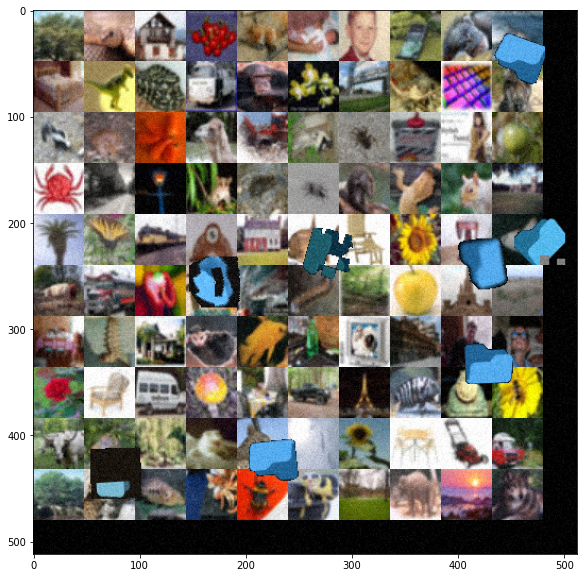

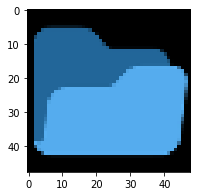

In [3]:
import matplotlib.pyplot as plt
import cv2
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.show()
plt.figure(figsize = (3,3))
imgplot2 = plt.imshow(cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB))
plt.show()

[(216, 477), (425, 226), (332, 429), (256, 171), (436, 78), (229, 277), (46, 458), (239, 423)]


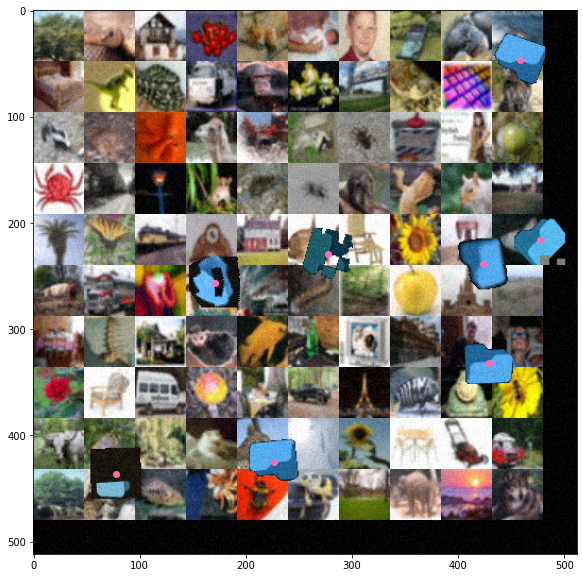

In [5]:
# desired output
plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
print(gt_points)
x = []
y = []
for a, b in gt_points:
  x.append(a)
  y.append(b)
plt.scatter(y, x, color = 'hotpink')
plt.show()

In [8]:
def myHistogram(img):
  H = np.zeros((3, 256), int)

  for row in img:
    for col in row:
      for ind in range(0,3):
        I = col[ind]
        H[ind][I] = H[ind][I]+1

  return H

In [9]:
#compares 2 histograms using Chi-square distances
# d(x, y) = .5*sum(xi-yi/xi+yi)
def histCompare(h_target, h_test):
  sums = [0, 0, 0]

  for col in range(0, 3):
    for i in range(0, 255):
      if h_target[col][i] > 0:
        sums[col] = sums[col] + ((h_target[col][i]-h_test[col][i])**2/(h_target[col][i]+h_test[col][i]))

  final = .5* sum(sums)
  return final

In [6]:
def printHist(H):
  plt.figure(figsize = (12,7))
  plt.subplot(2, 1, 1)
  plt.bar(np.arange(256),H[0])
  plt.title('r')
  plt.subplot(2, 1, 1)
  plt.plot(np.arange(256),H[1])
  plt.title('g')
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
  plt.subplot(2, 1, 1)
  plt.plot(np.arange(256),H[2])
  plt.title('b')
  plt.subplots_adjust(hspace=0.4, wspace=0.4)
  plt.show()

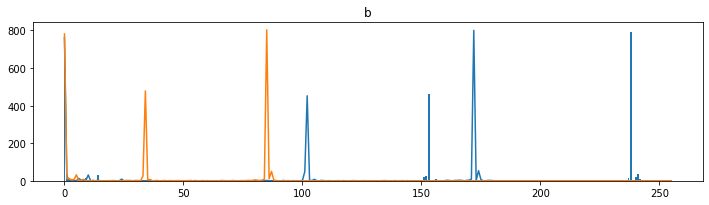

2931.4065667430987
2853.255033183995
2732.805766436989
2667.574392457501
2623.3713880770097
2692.752293410638
2827.4835552915365
2775.839163752652
2709.176297887111
2673.439324394558
2990.9632667336127
2804.636437684863
2968.402978873249
2640.145010412023
2623.229281525844
2754.563716694898
2809.4511733488307
2817.903430811905
2714.388974394165
2702.648343315544
2789.79515711056
2926.428805501335
2963.8303278252224
2864.4832974110504
2753.4052095172697
2728.774500971878
2775.03005986353
2827.5969270356372
2761.732695254075
2696.8574545235065
2650.4838431222556
2704.8313352722034
2695.11132510108
2761.6263093056887
2770.5992607989992
2857.3073220387914
2861.849275126987
2786.9535831008443
2775.265569427765
2785.928893326399
2758.897101002164
2712.6815935680625
2652.0391191533067
2636.7752562935802
2712.9879160351406
2851.3762429306707
2793.190891612123
2707.867049011485
2657.0123024528257
2666.3248924434783
2750.848806909398
2835.764104261153
2817.9368017261622
2792.3747971801563
2700.8

In [10]:
thresh = 0
spacing = 16  #to speed up

emoji_hist = myHistogram(emoji_target)
printHist(emoji_hist)

h, w, dim = test_image.shape
emjh, emjw, emjdim = emoji_target.shape

matches = []

for row in range(0, h, spacing):
  for col in range(0, w, spacing):
    if ((row+emjh)<h) and ((col+emjw)<w):
      img_slice = test_image[row:row+emjh,col:col+emjw,:]
      img_hist = myHistogram(img_slice)
      result = histCompare(emoji_hist, img_hist)

      if result < 3000:
        print(result)
        #printHist(img_hist)
        matches.append((row, col))

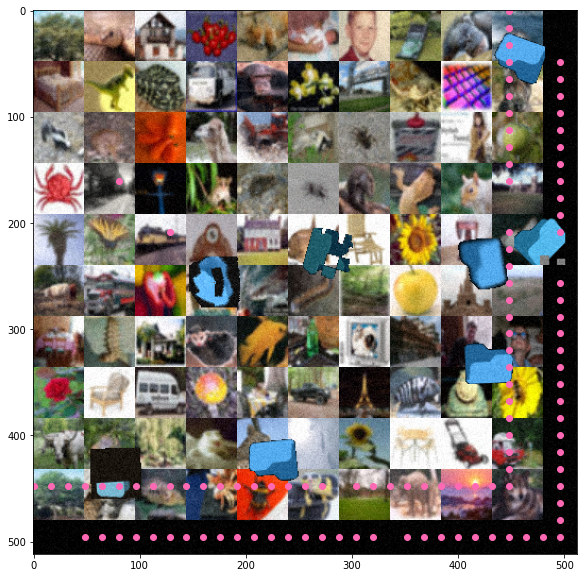

In [15]:
# results of prior block
plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
x = []
y = []
for a, b in matches:
  x.append(a)
  x.append(a+emjh)
  y.append(b)
  y.append(b+emjw)
plt.scatter(y, x, color = 'hotpink')
plt.show()